In [1]:
# import libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pathlib
from pathlib import Path
import os
import seaborn as sns
import datetime
import shapely
from shapely.geometry import shape, Point, LineString, Polygon

# set the working directory
BASE_DIR = Path.cwd()
print(BASE_DIR)

#set the project directory
project_folder = BASE_DIR.parent.parent
print(project_folder)

/tmp/pycharm_project_316/BEAM_Freight/Notebooks/GCE
/tmp/pycharm_project_316/BEAM_Freight


/home/goyal/.virtualenvs/venv_lbl_gce/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_89337/2539677943.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/lates

In [2]:
# Upload output in the respective bucket storage in the following path
# "gs://beam-core-outputs/output/city_name/simulation_name/Output/*" or
# "gs://beam-core-outputs/output/city_name/simulation_name/Output/plot/*" or

from google.cloud import storage
# Upload file to Google Cloud service
def upload_blob(_bucket_name, _source_file_name, _destination_blob_name):
    """Uploads a file to the bucket."""
    # The ID of your GCS bucket
    # bucket_name = "your-bucket-name"
    # The path to your file to upload
    # source_file_name = "local/path/to/file"
    # The ID of your GCS object
    # destination_blob_name = "storage-object-name"
    storage_client = storage.Client()
    bucket = storage_client.bucket(_bucket_name)
    blob = bucket.blob(_destination_blob_name)
    # Optional: set a generation-match precondition to avoid potential race conditions
    # and data corruptions. The request to upload is aborted if the object's
    # generation number does not match your precondition. For a destination
    # object that does not yet exist, set the if_generation_match precondition to 0.
    # If the destination object already exists in your bucket, set instead a
    # generation-match precondition using its generation number.
    generation_match_precondition = 0
    blob.upload_from_filename(_source_file_name, if_generation_match=generation_match_precondition)
    print(
        f"File {_source_file_name} uploaded to {_destination_blob_name}."
    )

def delete_blob(_bucket_name, _blob_name):
    """Deletes a blob from the bucket."""
    # bucket_name = "your-bucket-name"
    # blob_name = "your-object-name"

    storage_client = storage.Client()

    bucket = storage_client.bucket(_bucket_name)
    blob = bucket.blob(_blob_name)
    generation_match_precondition = None

    # Optional: set a generation-match precondition to avoid potential race conditions
    # and data corruptions. The request to delete is aborted if the object's
    # generation number does not match your precondition.
    blob.reload()  # Fetch blob metadata to use in generation_match_precondition.
    generation_match_precondition = blob.generation

    blob.delete(if_generation_match=generation_match_precondition)

    print(f"Blob {_blob_name} deleted.")

In [3]:
# Basic Reference Points
city_name="austin"
gcloud_bucket = "gs://beam-core-outputs/output/austin"
iter_no = "0"
linkstats_file_path = f"{iter_no}.linkstats.csv.gz"
network_file_path = "network.csv.gz"
event_files_path = f"{iter_no}.events.csv.gz"
simulation_name = "austin-base-with-freight-2018__2023-04-14_16-11-13_yoq"
analysis_type = "Freight"
#Check if the folder exist, if not create it.
try:
    pathlib.Path(project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "plot")).mkdir(parents=True, exist_ok=False)
except:
    pass

File /tmp/pycharm_project_316/BEAM_Freight/Output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Freight/plot/Austin_NPMRDS_hourly_mean_volume.png uploaded to output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Output/plot/Austin_NPMRDS_hourly_mean_volume.png.


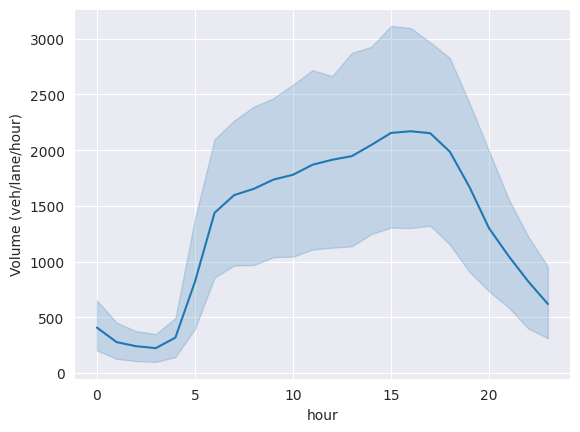

In [4]:
austin_NPMRDS_data = pd.read_csv(project_folder.joinpath("Reference_Data", city_name, "NPMRDS", "Austin_NPMRDS.csv"))

# select observed data for validation
austin_NPMRDS_data.loc[austin_NPMRDS_data['mean.spd']>= 80, 'mean.spd'] = 80

austin_NPMRDS_data_hourly_volume = austin_NPMRDS_data.groupby(['Tmc', 'hour'])[['flow_per_lane']].mean()
austin_NPMRDS_data_hourly_volume.columns = ['Volume (veh/lane/hour)']
austin_NPMRDS_data_hourly_volume = austin_NPMRDS_data_hourly_volume.reset_index()
austin_NPMRDS_data_hourly_speed = austin_NPMRDS_data.groupby(['Tmc', 'hour']).apply(lambda x: np.average(x['mean.spd'], weights=x['flow_per_lane']))
austin_NPMRDS_data_hourly_speed = austin_NPMRDS_data_hourly_speed.reset_index()
austin_NPMRDS_data_hourly_speed.columns = ['Tmc', 'hour', 'Avg.Speed (mph)']

austin_NPMRDS_data_hourly_data = pd.merge(austin_NPMRDS_data_hourly_volume,
                                          austin_NPMRDS_data_hourly_speed,
                                          on = ['Tmc', 'hour'], how = 'left')

sns.lineplot(data = austin_NPMRDS_data_hourly_data, x = "hour", y = "Volume (veh/lane/hour)", errorbar=('ci',95))
# plt.ylim([0, 70])
# plt.ylabel('average speed (mph)')
plt_file_name=f"Austin_NPMRDS_hourly_mean_volume.png"
plt.savefig(project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "plot", plt_file_name), dpi=600)
# plt.show()

bucket_name = "beam-core-outputs"
source_file_name = project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "plot",plt_file_name)
destination_blob_name = f"output/{city_name}/{simulation_name}/Output/plot/{plt_file_name}"
# Check if the file exist in the bucket. If "Yes", delete
try:
    delete_blob(_bucket_name=bucket_name, _blob_name=destination_blob_name)
except:
    pass
# and upload the file
upload_blob(bucket_name, source_file_name, destination_blob_name)

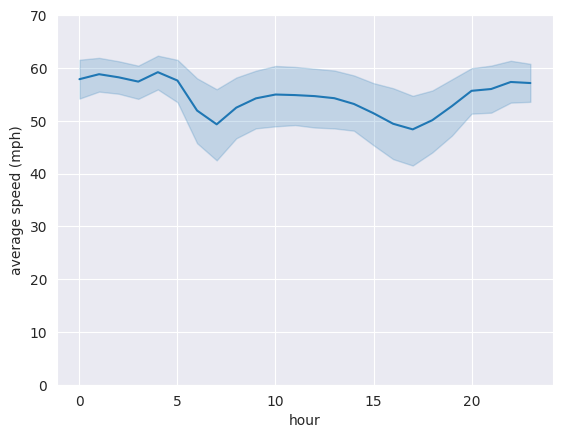

In [5]:
sns.lineplot(data = austin_NPMRDS_data_hourly_data, x = "hour", y = "Avg.Speed (mph)", errorbar=('ci',95))
plt.ylim([0, 70])
plt.ylabel('average speed (mph)')
plt_file_name=f"Austin_NPMRDS_hourly_mean_speed.png"
plt.savefig(project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "plot", plt_file_name), bbox_inches='tight', dpi = 600)
# plt.show()

In [6]:
# load BEAM output
modeled_vmt = pd.read_csv(f"{gcloud_bucket}/{simulation_name}/ITERS/it.{iter_no}/{linkstats_file_path}", compression="gzip", low_memory=True)
model_network = pd.read_csv(project_folder.joinpath("Reference_Data", city_name, "NPMRDS","BEAM_Network_NPMRDS_Screenline.csv"), low_memory=False)
meter_to_mile = 0.000621371
percent_of_samples = 0.5
mps_to_mph = 2.23694
model_network = model_network.drop_duplicates(subset=['linkId'])
# model_network.head(5)

In [7]:
# filter modeled network
model_vmt_24_hour = modeled_vmt.loc[(modeled_vmt['hour'] <= 28) & (modeled_vmt['hour'] >= 5)]
model_vmt_24_hour.loc[model_vmt_24_hour['hour']>=24, 'hour'] -= 24
model_network.loc[:, 'fromNodeId'] = model_network.loc[:, 'fromNodeId'].astype(int)
model_network.loc[:, 'toNodeId'] = model_network.loc[:, 'toNodeId'].astype(int)
model_vmt_24_hour = pd.merge(model_vmt_24_hour, model_network,
                             left_on = ['link', 'from', 'to'],
                             right_on = ['linkId', 'fromNodeId', 'toNodeId'], how = 'inner')

In [8]:
model_vmt_24_hour = model_vmt_24_hour.rename(columns = {'length_x': 'length_raw',
                                                        'length_y': 'length_adj'})
# print(model_vmt_24_hour.columns)

In [9]:
demand_scaling = 1/percent_of_samples
model_vmt_24_hour.loc[:, 'hourly volume'] = model_vmt_24_hour.loc[:, 'volume']/ \
                                            model_vmt_24_hour.loc[:, 'numberOfLanes']
model_vmt_24_hour.loc[:, 'VMT'] = demand_scaling * meter_to_mile * model_vmt_24_hour.loc[:, 'linkLength'] * model_vmt_24_hour.loc[:, 'volume']
# model_vmt_24_hour.loc[:, 'travel_time (hr)'] = model_vmt_24_hour.loc[:, 'linkLength'] /3600
model_vmt_24_hour.loc[:, 'speed'] = model_vmt_24_hour.loc[:, 'linkLength'] / model_vmt_24_hour.loc[:, 'traveltime']
model_vmt_24_hour.loc[:, 'speed (mph)'] = mps_to_mph * model_vmt_24_hour.loc[:, 'speed']

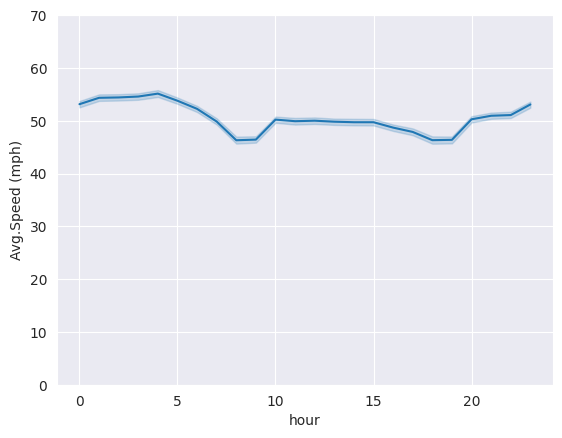

File /tmp/pycharm_project_316/BEAM_Freight/Output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Freight/plot/Austin_2017_modeled_speed_NPMRDS_screenline.png uploaded to output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Output/plot/Austin_2017_modeled_speed_NPMRDS_screenline.png.
File /tmp/pycharm_project_316/BEAM_Freight/Output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Freight/plot/Austin_2017_modeled_volume_NPMRDS_screenline.png uploaded to output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Output/plot/Austin_2017_modeled_volume_NPMRDS_screenline.png.


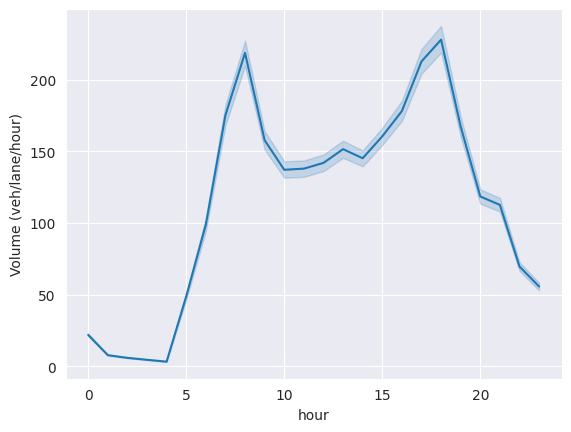

In [10]:
model_vmt_hour_volume = model_vmt_24_hour.groupby(['Tmc', 'hour'])[['hourly volume']].mean()
model_vmt_hour_volume = model_vmt_hour_volume.reset_index()
model_vmt_hour_volume.columns = ['Tmc', 'hour', 'Volume (veh/lane/hour)']
model_vmt_24_hour_filtered = model_vmt_24_hour.loc[model_vmt_24_hour['volume']>0]
model_vmt_hour_speed = model_vmt_24_hour_filtered.groupby(['Tmc', 'hour']).apply(lambda x: np.average(x.speed, weights=x.volume))
model_vmt_hour_speed = model_vmt_hour_speed.reset_index()
model_vmt_hour_speed.columns = ['Tmc', 'hour', 'Avg.Speed (mph)']
model_vmt_hour_speed.loc[:, 'Avg.Speed (mph)'] *= mps_to_mph

model_vmt_hour_data = pd.merge(model_vmt_hour_volume, model_vmt_hour_speed,
                               on = ['Tmc', 'hour'], how = 'left')
sns.lineplot(x = 'hour', y = 'Avg.Speed (mph)', data = model_vmt_hour_data, errorbar=('ci',95))
plt.ylim([0, 70])
plt_file_name = "Austin_2017_modeled_speed_NPMRDS_screenline.png"
plt.savefig(project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "plot", plt_file_name), dpi = 600)
plt.show()
bucket_name = "beam-core-outputs"
source_file_name = project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "plot",plt_file_name)
destination_blob_name = f"output/{city_name}/{simulation_name}/Output/plot/{plt_file_name}"

# Check if the file exist in the bucket. If "Yes", delete
try:
    delete_blob(_bucket_name=bucket_name, _blob_name=destination_blob_name)
except:
    pass
# and upload the file
upload_blob(bucket_name, source_file_name, destination_blob_name)

sns.lineplot(x = 'hour', y = 'Volume (veh/lane/hour)', data = model_vmt_hour_data, errorbar=('ci',95))
# plt.ylim([0, 70])
# plt.ylabel('volume (veh/lane/hour)')
plt_file_name=f"Austin_2017_modeled_volume_NPMRDS_screenline.png"
plt.savefig(project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "plot", plt_file_name), dpi = 600)

bucket_name = "beam-core-outputs"
source_file_name = project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "plot",plt_file_name)
destination_blob_name = f"output/{city_name}/{simulation_name}/Output/plot/{plt_file_name}"
# Check if the file exist in the bucket. If "Yes", delete
try:
    delete_blob(_bucket_name=bucket_name, _blob_name=destination_blob_name)
except:
    pass
# and upload the file
upload_blob(bucket_name, source_file_name, destination_blob_name)

In [11]:
# compare two datasets
austin_NPMRDS_data_hourly_data.loc[:, 'source'] = 'NPMRDS'
model_vmt_hour_data.loc[:, 'source'] = 'BEAM output'
combined_data = pd.concat([austin_NPMRDS_data_hourly_data, model_vmt_hour_data])
combined_data = combined_data.reset_index()

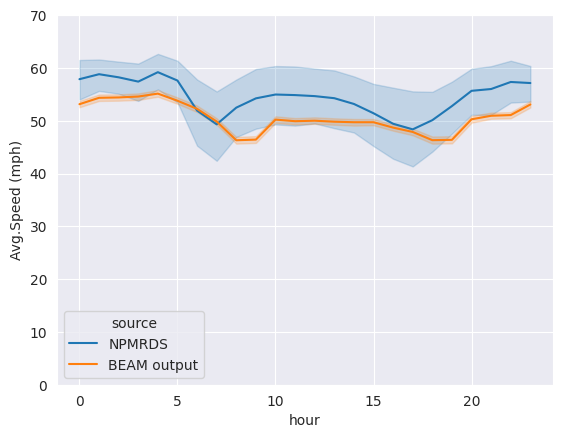

File /tmp/pycharm_project_316/BEAM_Freight/Output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Freight/plot/Austin_2017_BEAM_NPMRDS_screenline_speed_validation.png uploaded to output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Output/plot/Austin_2017_BEAM_NPMRDS_screenline_speed_validation.png.


In [12]:
sns.lineplot(x = 'hour', y = 'Avg.Speed (mph)', hue = 'source', data = combined_data, errorbar=('ci',95))
plt.ylim([0, 70])
plt_file_name=f"Austin_2017_BEAM_NPMRDS_screenline_speed_validation.png"
plt.savefig(project_folder.joinpath("Output", city_name, simulation_name, "Freight","plot", plt_file_name), dpi = 600)
plt.show()

bucket_name = "beam-core-outputs"
source_file_name = project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "plot",plt_file_name)
destination_blob_name = f"output/{city_name}/{simulation_name}/Output/plot/{plt_file_name}"
# Check if the file exist in the bucket. If "Yes", delete
try:
    delete_blob(_bucket_name=bucket_name, _blob_name=destination_blob_name)
except:
    pass
# and upload the file
upload_blob(bucket_name, source_file_name, destination_blob_name)

File /tmp/pycharm_project_316/BEAM_Freight/Output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Freight/plot/Austin_2017_BEAM_NPMRDS_screenline_volume_validation.png uploaded to output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Output/plot/Austin_2017_BEAM_NPMRDS_screenline_volume_validation.png.


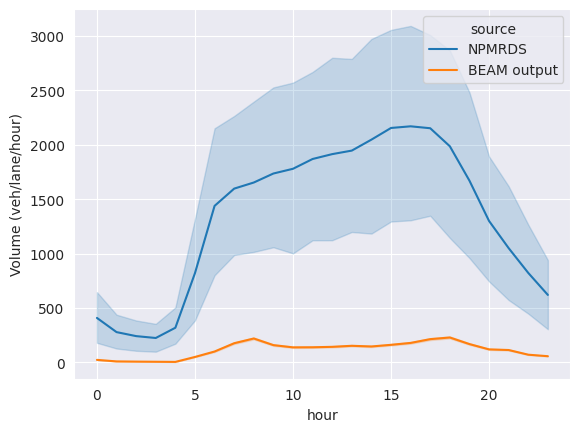

In [13]:
sns.lineplot(x = 'hour', y = 'Volume (veh/lane/hour)', hue = 'source', data = combined_data, errorbar=('ci',95))
# plt.ylim([0, 70])
# plt.ylabel('volume (veh/lane/hour)')
plt_file_name=f"Austin_2017_BEAM_NPMRDS_screenline_volume_validation.png"
plt.savefig(project_folder.joinpath("Output", city_name, simulation_name, "Freight","plot", plt_file_name), dpi = 600)
# plt.show()

bucket_name = "beam-core-outputs"
source_file_name = project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "plot",plt_file_name)
destination_blob_name = f"output/{city_name}/{simulation_name}/Output/plot/{plt_file_name}"
# Check if the file exist in the bucket. If "Yes", delete
try:
    delete_blob(_bucket_name=bucket_name, _blob_name=destination_blob_name)
except:
    pass
# and upload the file
upload_blob(bucket_name, source_file_name, destination_blob_name)

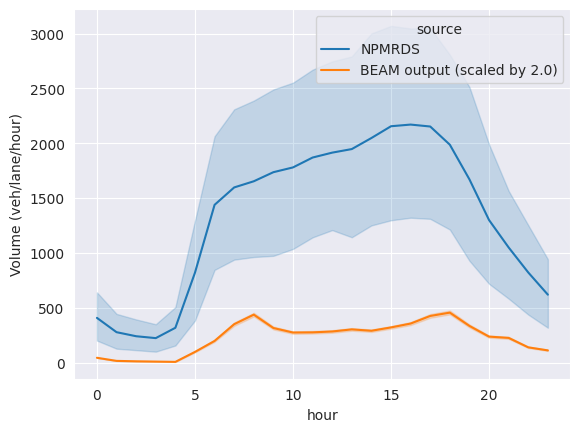

File /tmp/pycharm_project_316/BEAM_Freight/Output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Freight/plot/Austin_2017_BEAM_NPMRDS_screenline_scaled_volume_validation.png uploaded to output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Output/plot/Austin_2017_BEAM_NPMRDS_screenline_scaled_volume_validation.png.


In [14]:
model_vmt_hour_data_scaled = model_vmt_hour_data.copy()
model_vmt_hour_data_scaled.loc[:, 'Volume (veh/lane/hour)'] *= demand_scaling
model_vmt_hour_data_scaled.loc[:, 'source'] = f'BEAM output (scaled by {demand_scaling})'
#model_vmt_hour_data.loc[:, 'source'] = 'BEAM output'
combined_data_scaled = pd.concat([austin_NPMRDS_data_hourly_data, model_vmt_hour_data_scaled])
combined_data_scaled = combined_data_scaled.reset_index()
# combined_data_scaled.head(5)
sns.lineplot(x = 'hour', y = 'Volume (veh/lane/hour)', hue = 'source',
             data = combined_data_scaled, errorbar=('ci',95))
# plt.ylim([0, 70])
# plt.ylabel('volume (veh/lane/hour)')
plt_file_name=f"Austin_2017_BEAM_NPMRDS_screenline_scaled_volume_validation.png"
plt.savefig(project_folder.joinpath("Output", city_name, simulation_name, "Freight","plot", plt_file_name), dpi = 600)
plt.show()

bucket_name = "beam-core-outputs"
source_file_name = project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "plot",plt_file_name)
destination_blob_name = f"output/{city_name}/{simulation_name}/Output/plot/{plt_file_name}"
# Check if the file exist in the bucket. If "Yes", delete
try:
    delete_blob(_bucket_name=bucket_name, _blob_name=destination_blob_name)
except:
    pass
# and upload the file
upload_blob(bucket_name, source_file_name, destination_blob_name)

In [15]:
paired_data_for_comparison = pd.merge(austin_NPMRDS_data_hourly_data, model_vmt_hour_data,
                                      on = ['Tmc', 'hour'], how = 'left')
paired_data_for_comparison = paired_data_for_comparison.rename(columns = {'Avg.Speed (mph)_x': 'Austin NPMRDS speed',
                                                                          'Avg.Speed (mph)_y': 'BEAM speed',
                                                                          'Volume (veh/lane/hour)_x': 'Austin NPMRDS volume',
                                                                          'Volume (veh/lane/hour)_y': 'BEAM volume'})

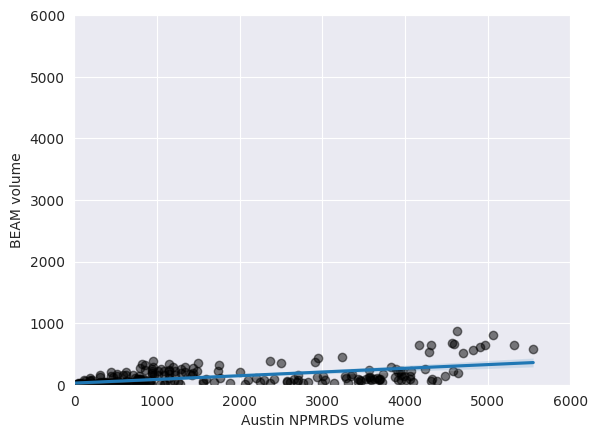

File /tmp/pycharm_project_316/BEAM_Freight/Output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Freight/plot/Austin_2017_paired_NPMRDS_screenline_volume_validation.png uploaded to output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Output/plot/Austin_2017_paired_NPMRDS_screenline_volume_validation.png.


In [16]:
sns.regplot(data=paired_data_for_comparison, x="Austin NPMRDS volume", y="BEAM volume",
            scatter_kws={"color": "black", 'alpha':0.5})
plt.xlim([0, 6000])
plt.ylim([0, 6000])
plt_file_name=f"Austin_2017_paired_NPMRDS_screenline_volume_validation.png"
plt.savefig(project_folder.joinpath("Output", city_name, simulation_name, "Freight","plot", plt_file_name), dpi = 600)
plt.show()

bucket_name = "beam-core-outputs"
source_file_name = project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "plot",plt_file_name)
destination_blob_name = f"output/{city_name}/{simulation_name}/Output/plot/{plt_file_name}"
# Check if the file exist in the bucket. If "Yes", delete
try:
    delete_blob(_bucket_name=bucket_name, _blob_name=destination_blob_name)
except:
    pass
# and upload the file
upload_blob(bucket_name, source_file_name, destination_blob_name)

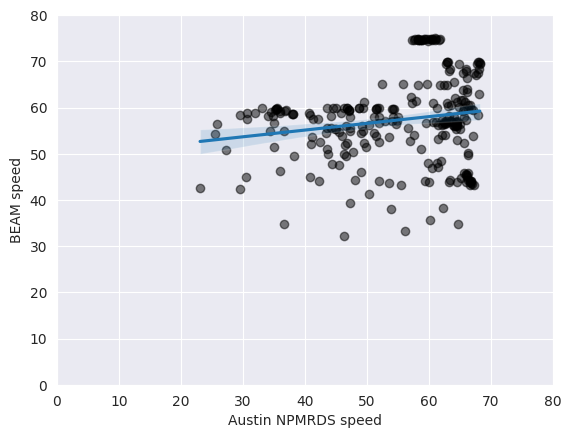

File /tmp/pycharm_project_316/BEAM_Freight/Output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Freight/plot/Austin_2017_paired_NPMRDS_screenline_speed_validation.png uploaded to output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Output/plot/Austin_2017_paired_NPMRDS_screenline_speed_validation.png.


In [17]:
sns.regplot(data=paired_data_for_comparison, x="Austin NPMRDS speed", y="BEAM speed",
            scatter_kws={"color": "black", 'alpha':0.5})
plt.xlim([0, 80])
plt.ylim([0, 80])
plt_file_name=f"Austin_2017_paired_NPMRDS_screenline_speed_validation.png"
plt.savefig(project_folder.joinpath("Output", city_name, simulation_name, "Freight","plot", plt_file_name), dpi = 600)
plt.show()

bucket_name = "beam-core-outputs"
source_file_name = project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "plot",plt_file_name)
destination_blob_name = f"output/{city_name}/{simulation_name}/Output/plot/{plt_file_name}"
# Check if the file exist in the bucket. If "Yes", delete
try:
    delete_blob(_bucket_name=bucket_name, _blob_name=destination_blob_name)
except:
    pass
# and upload the file
upload_blob(bucket_name, source_file_name, destination_blob_name)

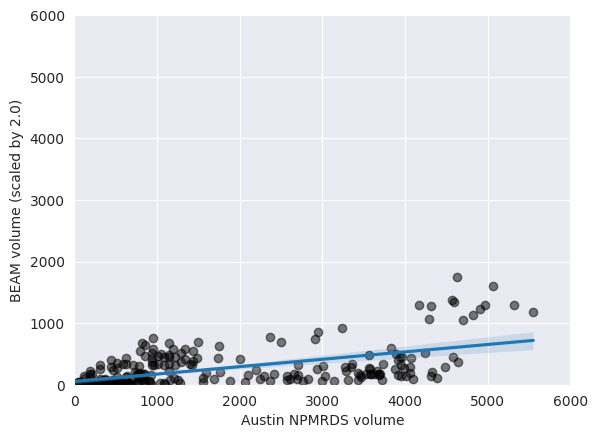

File /tmp/pycharm_project_316/BEAM_Freight/Output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Freight/plot/Austin_2017_paired_NPMRDS_screenline_scaled_volume_validation.png uploaded to output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Output/plot/Austin_2017_paired_NPMRDS_screenline_scaled_volume_validation.png.


In [18]:
paired_data_for_comparison.loc[:, f'BEAM volume (scaled by {demand_scaling})'] = paired_data_for_comparison.loc[:, 'BEAM volume'] * demand_scaling
sns.regplot(data=paired_data_for_comparison, x="Austin NPMRDS volume", y=f'BEAM volume (scaled by {demand_scaling})',
            scatter_kws={"color": "black", 'alpha':0.5})
plt.xlim([0, 6000])
plt.ylim([0, 6000])
plt_file_name=f"Austin_2017_paired_NPMRDS_screenline_scaled_volume_validation.png"
plt.savefig(project_folder.joinpath("Output", city_name, simulation_name, "Freight","plot", plt_file_name), dpi = 600)
plt.show()

bucket_name = "beam-core-outputs"
source_file_name = project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "plot",plt_file_name)
destination_blob_name = f"output/{city_name}/{simulation_name}/Output/plot/{plt_file_name}"
# Check if the file exist in the bucket. If "Yes", delete
try:
    delete_blob(_bucket_name=bucket_name, _blob_name=destination_blob_name)
except:
    pass
# and upload the file
upload_blob(bucket_name, source_file_name, destination_blob_name)

In [19]:
model_network_with_observed_traffic = pd.merge(model_network, austin_NPMRDS_data_hourly_data,
                                               on = 'Tmc', how = 'left')
model_network_with_observed_traffic.loc[:, 'Volume(veh/hour)'] = model_network_with_observed_traffic.loc[:, 'Volume (veh/lane/hour)'] * \
                                                                 model_network_with_observed_traffic.loc[:, 'numberOfLanes']
list_of_out_var = ['linkId', 'linkLength', 'linkFreeSpeed', 'linkCapacity',
                   'numberOfLanes', 'linkModes', 'attributeOrigId',
                   'attributeOrigType', 'fromNodeId', 'toNodeId', 'name',
                   'hour', 'Avg.Speed (mph)', 'Volume(veh/hour)', 'source']
model_network_with_observed_traffic = model_network_with_observed_traffic.loc[:, list_of_out_var]
model_network_with_observed_traffic = model_network_with_observed_traffic.dropna()
df_file_name = "observed_data_for_validation_part_2.csv"
model_network_with_observed_traffic.to_csv(project_folder.joinpath("Output", city_name, simulation_name, analysis_type, df_file_name), index = False)

bucket_name = "beam-core-outputs"
source_file_name = project_folder.joinpath("Output", city_name, simulation_name, analysis_type, df_file_name)
destination_blob_name = f"output/{city_name}/{simulation_name}/Output/{df_file_name}"
# Check if the file exist in the bucket. If "Yes", delete
try:
    delete_blob(_bucket_name=bucket_name, _blob_name=destination_blob_name)
except:
    pass
# and upload the file
upload_blob(bucket_name, source_file_name, destination_blob_name)

File /tmp/pycharm_project_316/BEAM_Freight/Output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Freight/observed_data_for_validation_part_2.csv uploaded to output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Output/observed_data_for_validation_part_2.csv.
